In [1]:
import pandas as pd

# Load datasets
coworking_df = pd.read_csv('Coworking Space In Morocco.csv')
marketing_df = pd.read_csv('Marketing Agency In Morocco.csv')

# Quick inspection
print("Coworking Space Dataset Shape:", coworking_df.shape)
print(coworking_df.head())

print("Marketing Agency Dataset Shape:", marketing_df.shape)
print(marketing_df.head())


Coworking Space Dataset Shape: (563, 43)
                      place_id  \
0  ChIJyWO4Ydq3sw0RabTa1I4CNBE   
1  ChIJsZNCAPq3sw0RZ0luc4iVNYo   
2  ChIJfwom57fJsw0R06gfpYjQ9E4   
3  ChIJW0v7EGW3sw0RtqRMDzwAMfw   
4  ChIJ4am5D_rJsw0R-VugqMYvslI   

                                                name  \
0  O'Clock Coworking Space Agadir - Espace de tra...   
1        Coworking Space Agadir - Work Harmony Space   
2                                  Technopark Agadir   
3                      Social Innovation Space - SIS   
4                                           Y'office   

                                         description  is_spending_on_ads  \
0  Situé au cœur d’Agadir, O'clock Coworking est ...               False   
1  Work Harmony est un espace de coworking modern...               False   
2  Fédérateur stratégique de l'écosystème entrepr...               False   
3                                                NaN               False   
4  📍Louez une salle de Formation ou d

In [2]:
# Convert column names to lowercase and replace spaces with underscores
coworking_df.columns = coworking_df.columns.str.lower().str.replace(' ', '_')
marketing_df.columns = marketing_df.columns.str.lower().str.replace(' ', '_')

# Optional: List common columns
common_cols = list(set(coworking_df.columns).intersection(set(marketing_df.columns)))
print("Common columns for analysis:", common_cols)


Common columns for analysis: ['images', 'menu', 'is_permanently_closed', 'plus_code', 'coordinates', 'workday_timing', 'price_range', 'phone', 'can_claim', 'query', 'main_category', 'cid', 'most_popular_times', 'detailed_reviews', 'reservations', 'reviews_link', 'reviews_per_rating', 'name', 'featured_image', 'competitors', 'closed_on', 'place_id', 'time_zone', 'order_online_links', 'is_temporarily_closed', 'is_spending_on_ads', 'categories', 'owner', 'featured_reviews', 'hours', 'featured_question', 'about', 'website', 'review_keywords', 'data_id', 'description', 'detailed_address', 'address', 'popular_times', 'reviews', 'status', 'rating', 'link']


In [3]:
import json
import pandas as pd
import numpy as np

def safe_json_len(x):
    try:
        return len(json.loads(x))
    except:
        return 0

def clean_dataset(df):
    # Remove duplicates
    df = df.drop_duplicates(subset='place_id')
    
    # Ensure correct types
    df['rating'] = pd.to_numeric(df.get('rating', 0), errors='coerce').fillna(0)
    df['reviews'] = pd.to_numeric(df.get('reviews', 0), errors='coerce').fillna(0)
    df['is_spending_on_ads'] = df.get('is_spending_on_ads', False).fillna(False).astype(bool)

    # Handle competitors JSON
    if 'competitors' in df.columns:
        df['num_competitors'] = df['competitors'].apply(lambda x: safe_json_len(x) if pd.notnull(x) else 0)
    else:
        df['num_competitors'] = 0

    # Handle review_keywords JSON
    if 'review_keywords' in df.columns:
        df['num_keywords'] = df['review_keywords'].apply(lambda x: safe_json_len(x) if pd.notnull(x) else 0)
    else:
        df['num_keywords'] = 0

    # Feature: ad_spend_flag
    df['ad_spend_flag'] = df['is_spending_on_ads'].apply(lambda x: 1 if x else 0)

    # Handle hours JSON
    if 'hours' in df.columns:
        df['operating_hours_count'] = df['hours'].apply(lambda x: safe_json_len(x) if pd.notnull(x) else 0)
    else:
        df['operating_hours_count'] = 0

    # Engagement metrics
    df['engagement_rate'] = df['reviews'] / df['operating_hours_count'].replace(0, 1)
    df['ad_efficiency'] = df['ad_spend_flag'] / df['reviews'].replace(0, 1)
    
    return df

# Apply cleaning
coworking_df = clean_dataset(coworking_df)
marketing_df = clean_dataset(marketing_df)


In [4]:
# Already cleaned:
# coworking_df
# marketing_df

print("Coworking dataset shape:", coworking_df.shape)
print("Marketing dataset shape:", marketing_df.shape)


Coworking dataset shape: (563, 49)
Marketing dataset shape: (2625, 49)


In [5]:
# Find common columns only
common_cols = list(set(coworking_df.columns).intersection(set(marketing_df.columns)))

# Combine using common columns
combined_df = pd.concat([
    coworking_df[common_cols],
    marketing_df[common_cols]
], axis=0, ignore_index=True)


In [6]:
print("Coworking dataset shape:", coworking_df.shape)
print("Marketing dataset shape:", marketing_df.shape)

Coworking dataset shape: (563, 49)
Marketing dataset shape: (2625, 49)


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by main_category
funnel_data = combined_df.groupby('main_category').agg({
    'reviews': 'sum',
    'ad_spend_flag': 'sum',
    'engagement_rate': 'mean'
}).reset_index()

# Rename for clarity (optional)
funnel_data.columns = ['Category', 'Total Reviews', 'Total Ad Spenders', 'Avg Engagement Rate']

print("Funnel Data Summary:")
print(funnel_data)


Funnel Data Summary:
                   Category  Total Reviews  Total Ad Spenders  \
0       3D printing service              3                  0   
1                Accountant             49                  0   
2           Accounting firm              1                  0   
3    Adult education school             43                  0   
4        Advertising agency           3179                  0   
..                      ...            ...                ...   
246  Volunteer organization              1                  0   
247               Warehouse              1                  0   
248     Web hosting company             61                  0   
249        Website designer           1879                  0   
250         Wellness center              6                  0   

     Avg Engagement Rate  
0               1.500000  
1               9.800000  
2               1.000000  
3              21.500000  
4               8.130435  
..                   ...  
246      

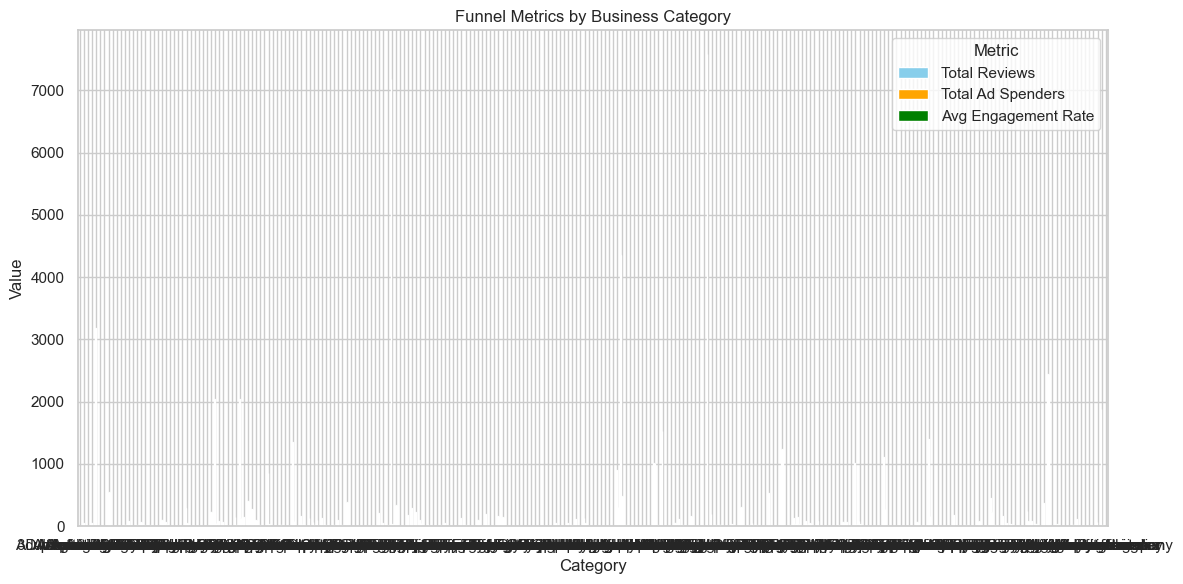

In [8]:
# Set plot style
sns.set(style='whitegrid')

# Plot bar chart for all 3 metrics
funnel_data.set_index('Category').plot(
    kind='bar',
    figsize=(12, 6),
    color=['skyblue', 'orange', 'green']
)

plt.title('Funnel Metrics by Business Category')
plt.ylabel('Value')
plt.xticks(rotation=0)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


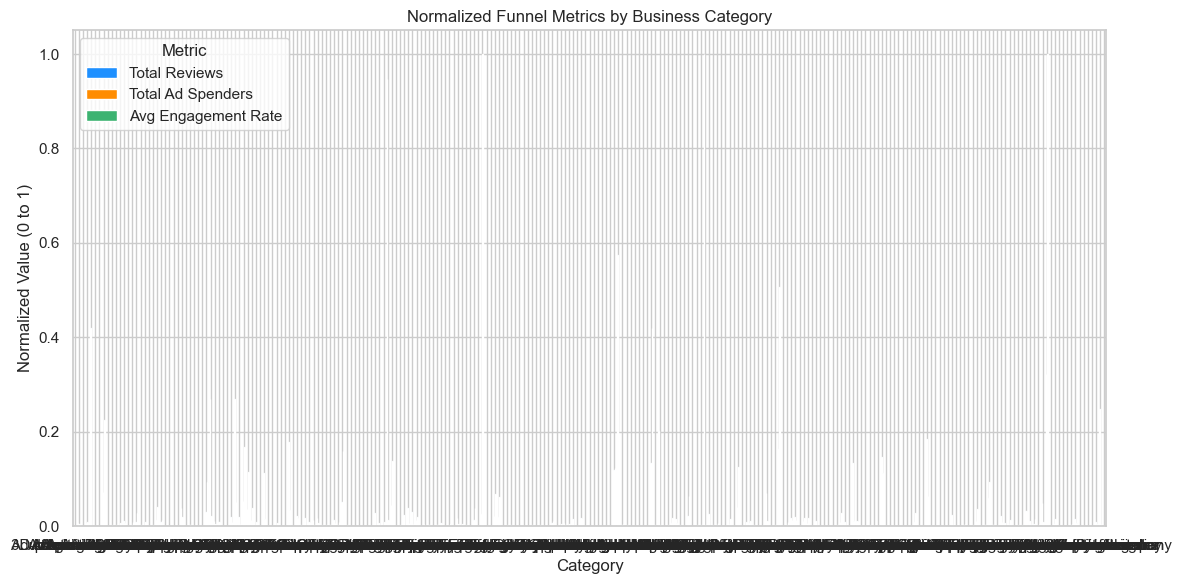

In [17]:
# Normalize values between 0 and 1
funnel_norm = funnel_data.copy()
funnel_norm[['Total Reviews', 'Total Ad Spenders', 'Avg Engagement Rate']] = funnel_norm[[
    'Total Reviews', 'Total Ad Spenders', 'Avg Engagement Rate'
]] / funnel_norm[[
    'Total Reviews', 'Total Ad Spenders', 'Avg Engagement Rate'
]].max()

# Plot normalized funnel
funnel_norm.set_index('Category').plot(
    kind='bar',
    figsize=(12, 6),
    color=['dodgerblue', 'darkorange', 'mediumseagreen']
)

plt.title('Normalized Funnel Metrics by Business Category')
plt.ylabel('Normalized Value (0 to 1)')
plt.xticks(rotation=0)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


In [18]:
# Group by city
city_funnel = combined_df.groupby('city').agg({
    'reviews': 'sum',
    'ad_spend_flag': 'sum',
    'engagement_rate': 'mean'
}).reset_index()

# Top 10 cities by reviews
top_cities = city_funnel.sort_values(by='reviews', ascending=False).head(10)

# Plot
top_cities.set_index('city').plot(kind='bar', figsize=(14, 6), color=['skyblue', 'orange', 'green'])
plt.title('Top 10 Cities by Funnel Metrics')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


KeyError: 'city'

In [9]:
print("Columns in combined_df:")
print(combined_df.columns.tolist())


Columns in combined_df:
['images', 'num_keywords', 'menu', 'is_permanently_closed', 'plus_code', 'coordinates', 'engagement_rate', 'workday_timing', 'price_range', 'phone', 'can_claim', 'query', 'main_category', 'cid', 'most_popular_times', 'detailed_reviews', 'ad_efficiency', 'reviews_link', 'reservations', 'name', 'reviews_per_rating', 'featured_image', 'competitors', 'closed_on', 'ad_spend_flag', 'place_id', 'time_zone', 'num_competitors', 'order_online_links', 'is_temporarily_closed', 'is_spending_on_ads', 'categories', 'owner', 'featured_reviews', 'operating_hours_count', 'hours', 'featured_question', 'about', 'website', 'review_keywords', 'data_id', 'description', 'detailed_address', 'address', 'popular_times', 'reviews', 'status', 'rating', 'link']


In [10]:
# Example: extract city from 'address' column
if 'address' in combined_df.columns:
    combined_df['city'] = combined_df['address'].apply(
        lambda x: x.split(',')[-2].strip() if pd.notnull(x) and ',' in x else 'Unknown'
    )


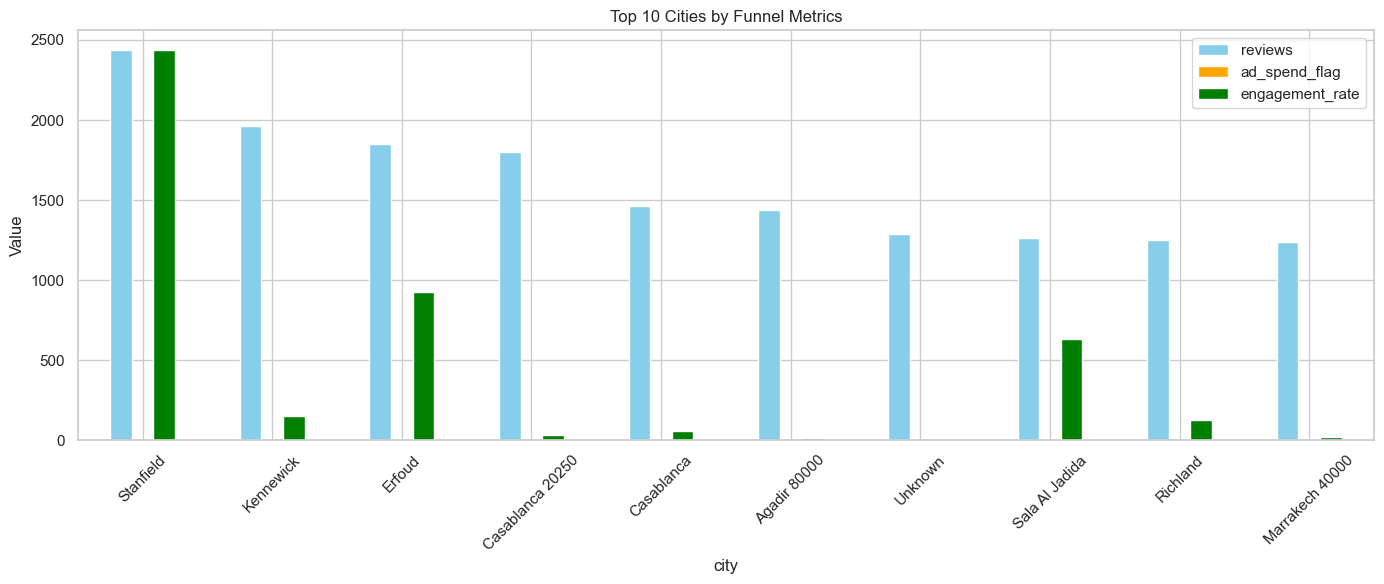

In [11]:
city_funnel = combined_df.groupby('city').agg({
    'reviews': 'sum',
    'ad_spend_flag': 'sum',
    'engagement_rate': 'mean'
}).reset_index()

# Plot top cities
top_cities = city_funnel.sort_values(by='reviews', ascending=False).head(10)
top_cities.set_index('city').plot(kind='bar', figsize=(14, 6), color=['skyblue', 'orange', 'green'])
plt.title('Top 10 Cities by Funnel Metrics')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
combined_df['month'] = pd.to_datetime(combined_df['timestamp'], errors='coerce').dt.to_period('M')
trend = combined_df.groupby(['month', 'city'])['reviews'].sum().unstack().fillna(0)
trend.plot(figsize=(14, 6), title='Monthly Reviews by City')
plt.ylabel('Total Reviews')
plt.show()


KeyError: 'timestamp'

In [ ]:
import seaborn as sns

heat_data = combined_df.pivot_table(
    index='city', columns='main_category', values='engagement_rate', aggfunc='mean'
).fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(heat_data, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title("Average Engagement Rate by City and Category")
plt.show()


In [ ]:
import xgboost as xgb
import shap

# Define features and target
features = ['ad_spend_flag', 'num_competitors', 'operating_hours_count']
target = 'rating'

X = combined_df[features]
y = combined_df[target]


In [ ]:
# Train model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X, y)


In [ ]:
# Create SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X)


In [ ]:
# Visualize
shap.summary_plot(shap_values, X)


In [ ]:
# Explain a single row (e.g., row 10)
shap.plots.waterfall(shap_values[10])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define features and target
features = [
    'ad_spend_flag',
    'num_competitors',
    'operating_hours_count',
    'num_keywords',
    'reviews',
    'engagement_rate',
    'ad_efficiency'
]
target = 'rating'

# Clean up any rows with missing values in selected columns
model_data = combined_df[features + [target]].dropna()

X = model_data[features]
y = model_data[target]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
from xgboost import XGBRegressor

# Initialize and train model
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)


In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluation metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"🔍 RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"📈 R² Score: {r2:.2f}")


In [ ]:
pip install textblob


In [ ]:
from textblob import TextBlob
import json


In [ ]:
[{"text": "Amazing service!", "rating": 5}, ...]


In [ ]:
def extract_review_text(review_json):
    try:
        reviews = json.loads(review_json)
        if isinstance(reviews, list) and len(reviews) > 0 and 'text' in reviews[0]:
            return reviews[0]['text']
    except:
        return ""
    return ""
    
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity if text else 0


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.histplot(combined_df['sentiment'], bins=30, kde=True, color='purple')
plt.title('Distribution of Sentiment Polarity from Featured Reviews')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()
